# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project Tasks

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [62]:
taxi_df = pd.read_csv('/datasets/taxi.csv')

In [63]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [64]:
display(taxi_df)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


Dates range from March 1st 2018 - August 31st 2018

In [65]:
taxi_df['datetime'] = pd.to_datetime(taxi_df['datetime'])

In [66]:
taxi_df.duplicated().sum()

0

In [67]:
taxi_df.index.is_monotonic

True

In [68]:
taxi_df = taxi_df.set_index('datetime')

## Analysis

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]


Text(0.5, 1.0, 'Taxi Orders March 2018 - August 2018')

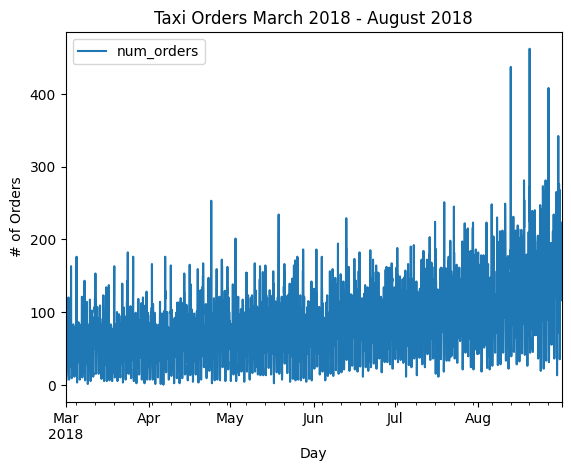

In [69]:
taxi_df = taxi_df.resample('1H').sum()
print(taxi_df)
taxi_df.plot()
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.title('Taxi Orders March 2018 - August 2018')

Number of Orders tend to increase through the months and substainally grow in August.

In [70]:
def test(timeseries):
    rollingmean = timeseries.rolling(6).mean()
    rollingstd = timeseries.rolling(6).std()
    
    original = plt.plot(timeseries, color='blue', label='Original')
    rolling = plt.plot(rollingmean, color='orange', label='Rolling')
    std = plt.plot(rollingstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Std')
    plt.show(block=False)

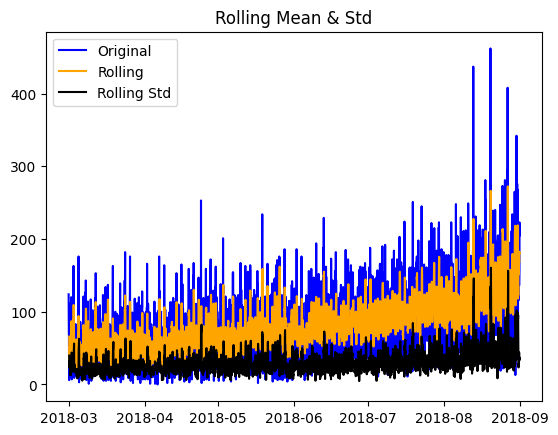

In [71]:
test(taxi_df)

Data is staitonary

In [72]:
taxi_df.duplicated().sum()

4165

In [73]:
taxi_df.isna().sum()

num_orders    0
dtype: int64

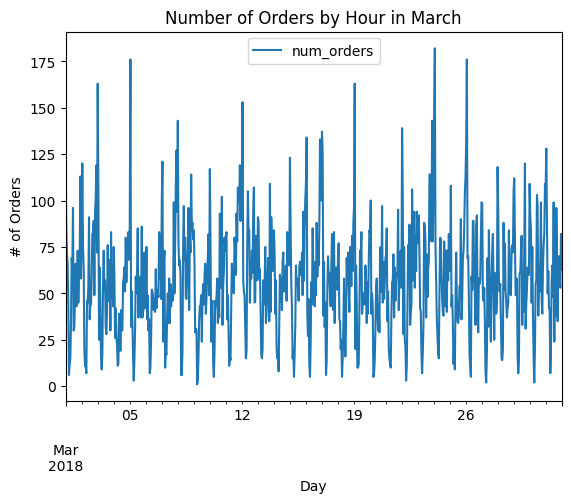

In [74]:
taxi_df['2018-03-01':'2018-03-31'].plot()
plt.title('Number of Orders by Hour in March')
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.show()

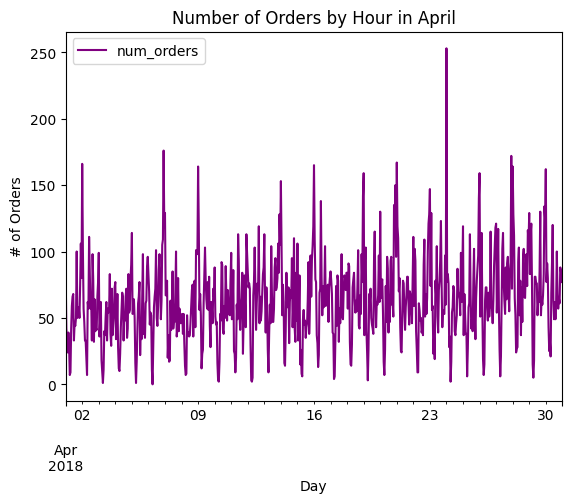

In [76]:
taxi_df['2018-04-01':'2018-04-30'].plot(color='purple')
plt.title('Number of Orders by Hour in April')
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.show()

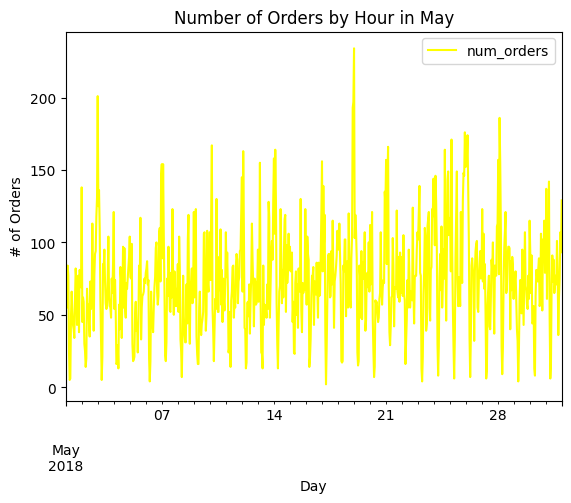

In [77]:
taxi_df['2018-05-01':'2018-05-31'].plot(color='yellow')
plt.title('Number of Orders by Hour in May')
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.show()

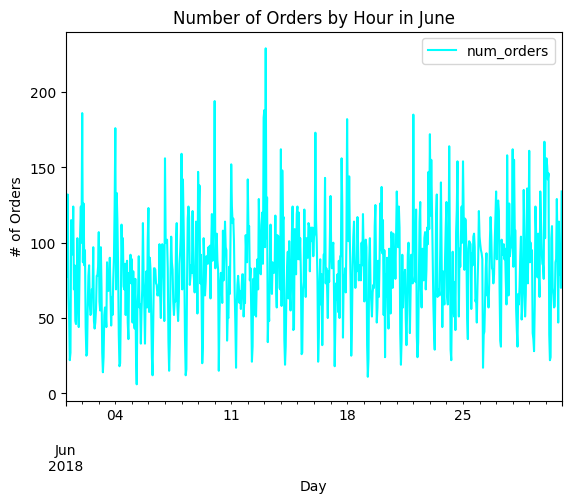

In [78]:
taxi_df['2018-06-01':'2018-06-30'].plot(color='aqua')
plt.title('Number of Orders by Hour in June')
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.show()

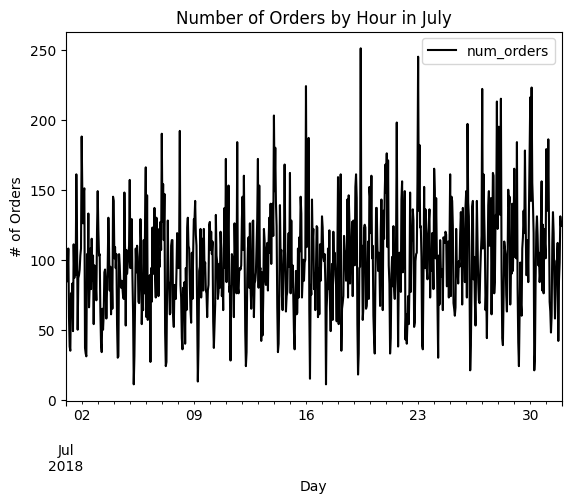

In [79]:
taxi_df['2018-07-01':'2018-07-31'].plot(color='black')
plt.title('Number of Orders by Hour in July')
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.show()

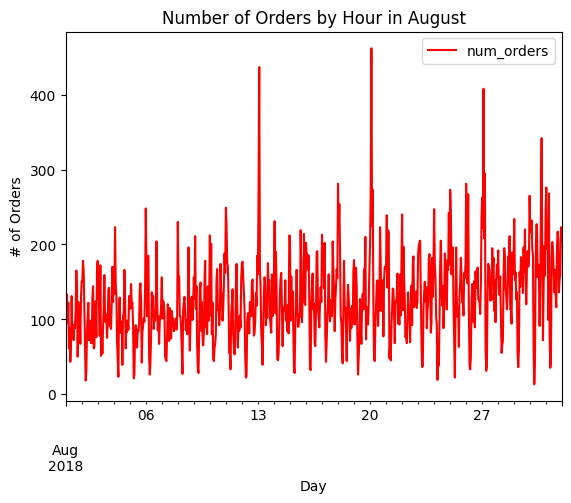

In [80]:
taxi_df['2018-08-01':'2018-08-31'].plot(color='red')
plt.title('Number of Orders by Hour in August')
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.show()

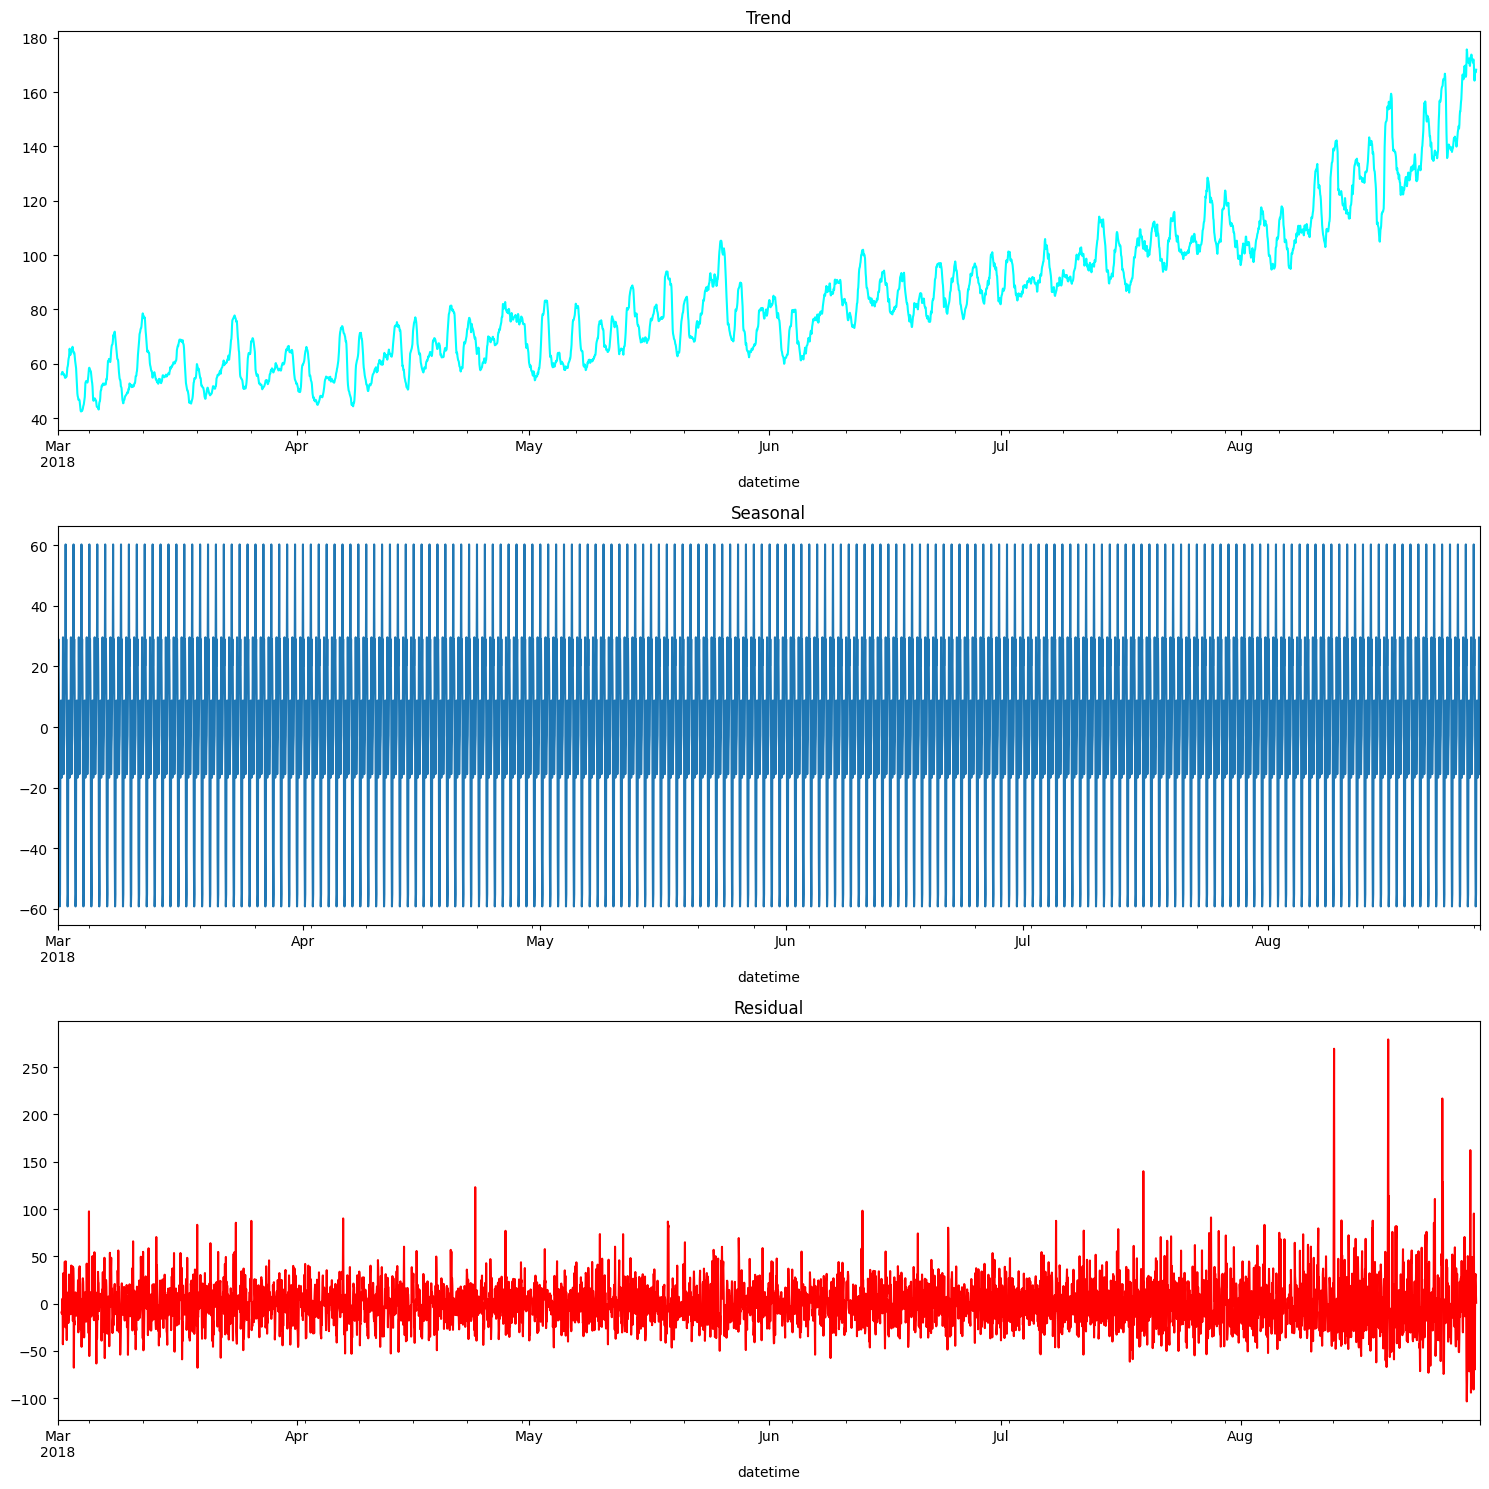

In [41]:
march_data = taxi_df['2018-03-01':'2018-08-31']['num_orders']


result = seasonal_decompose(march_data, model='additive', period=24)  # Assuming a daily seasonality with a period of 24 hours


fig, axes = plt.subplots(3, 1, figsize=(15, 15))

result.trend.plot(ax=axes[0],color='aqua')
axes[0].set_title('Trend')

result.seasonal[:-100].plot(ax=axes[1])
axes[1].set_title('Seasonal')

result.resid.plot(ax=axes[2], color='red')
axes[2].set_title('Residual')


plt.tight_layout()
plt.show()

Seasonality is consistent. As we reach August, an increase in orders spikes.

## Training

In [51]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.day_of_week 
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df 

In [52]:
taxi_df = make_features(taxi_df, 4, 4)

In [53]:
taxi_df

,num_orders,month,day,hour,day_of_week,lag_1,rolling_mean,lag_2,lag_3,lag_4
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,NaN,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,NaN,85.0,124.0,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,86.50,71.0,85.0,124.0
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,19,4,207.0,184.25,217.0,197.0,116.0
2018-08-31 20:00:00,154,8,31,20,4,136.0,189.25,207.0,217.0,197.0
2018-08-31 21:00:00,159,8,31,21,4,154.0,178.50,136.0,207.0,217.0


In [54]:
train, test = train_test_split(taxi_df, shuffle=False, test_size=.1)
train, valid = train_test_split(train, shuffle=False, test_size=.3)

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

In [55]:
model = LinearRegression()
model.fit(features_train, target_train)

pred_valid = model.predict(features_valid)

mse = mean_squared_error(target_valid, pred_valid)
rmse = np.sqrt(mse)

print('RMSE: ', rmse)

RMSE:  36.537100687237654


In [56]:
model = RandomForestRegressor(n_estimators=150, max_depth=12, random_state=12345)
model.fit(features_train, target_train)

pred_valid = model.predict(features_valid)

mse = mean_squared_error(target_valid, pred_valid)

rmse = np.sqrt(mse)

print('RMSE:', rmse)

RMSE: 32.75412220172324


In [57]:
param_grid = {
    'max_depth': [5, 7, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = DecisionTreeRegressor(random_state=12345)

cv = TimeSeriesSplit()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

grid_search.fit(features_train, target_train)

best_model = grid_search.best_estimator_

pred_valid = best_model.predict(features_valid)

mse = mean_squared_error(target_valid, pred_valid)
rmse = np.sqrt(mse)

print("Best Parameters:", grid_search.best_params_)
print("RMSE:", rmse)

Best Parameters: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}
RMSE: 37.47746884421884


## Testing

In [58]:
train_valid = pd.concat([train, valid])  # Concatenate train and validation sets

train_valid = train_valid.dropna()

features_train_valid = train_valid.drop(['num_orders'], axis=1)
target_train_valid = train_valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

model = RandomForestRegressor(n_estimators=150, max_depth=12, random_state=12345)
model.fit(features_train_valid, target_train_valid)

pred_test = model.predict(features_test)

mse = mean_squared_error(target_test, pred_test)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 47.28134182983693


## Conclusion

After reading and resampling the data to show the number of orders per hour, we see that the data is stationary in all months. From looking at the trend and seasonality, the orders seem to stay consistent with a substaintial increase over time. August seemed to be the month where there is a large increase in orders called.

Using LinearRegression, Random Forest, and hyperparameter tuning with the DecisionTree, we found that the RandomForest model had the lowest RMSE score of 3. Overall the real number of taxi orders for a specific hour is 100, the model's predictions range from 52.61